In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from pathlib import Path

In [193]:
BASE_DIR = Path.cwd()
ROOT_DIR = BASE_DIR.parent
file_path = ROOT_DIR / 'Datasets' / 'weekly_customer_complaints.csv'
print(file_path)

c:\Users\shiva\OneDrive\Documents\TimeSeriesForecasting\Datasets\weekly_customer_complaints.csv


In [194]:
df = pd.read_csv(file_path,index_col='week',parse_dates=True)
df.index.freq = 'W-Mon'
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,"1,750",37.26%,1,0,0
2018-01-08,"1,701",35.38%,0,0,0
2018-01-15,"1,711",36.22%,1,0,0
2018-01-22,"1,443",38.33%,1,0,0
2018-01-29,"1,397",36.34%,0,0,0


In [196]:
df = df.rename(columns={'complaints':'y'})[['y']]
df.head()

,y
week,
2018-01-01,"1,750"
2018-01-08,"1,701"
2018-01-15,"1,711"
2018-01-22,"1,443"
2018-01-29,"1,397"


In [197]:
df['y'] = df['y'].str.replace(',','').astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2018-01-01 to 2022-12-26
Freq: W-MON
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       261 non-null    int64
dtypes: int64(1)
memory usage: 4.1 KB


### Compliants over time

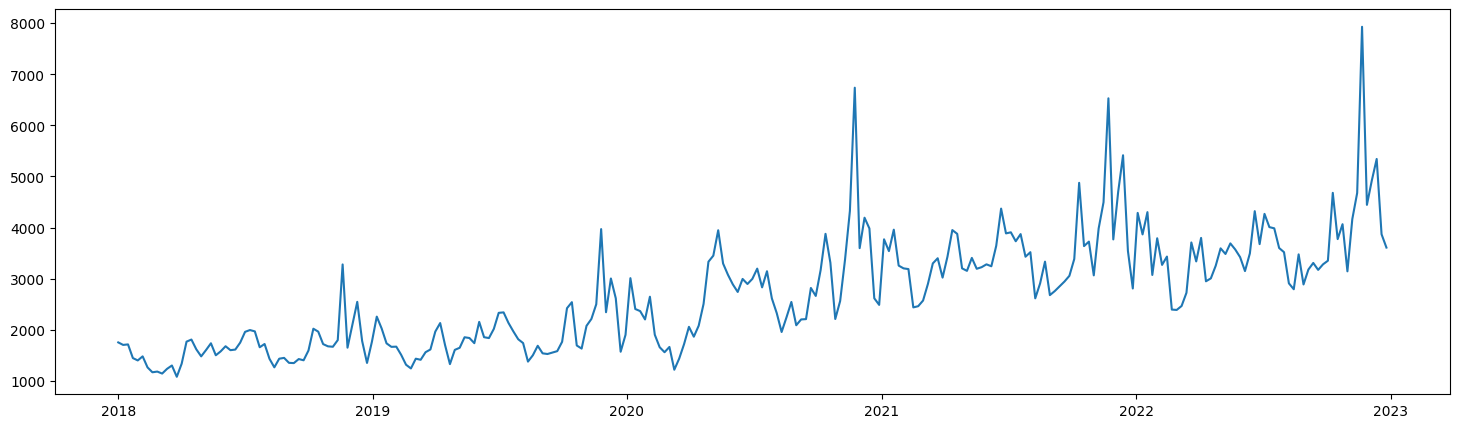

In [198]:
fig = plt.figure(figsize=(18,5))
plt.plot(df['y'])
plt.show()

### Seasonal Decomposition

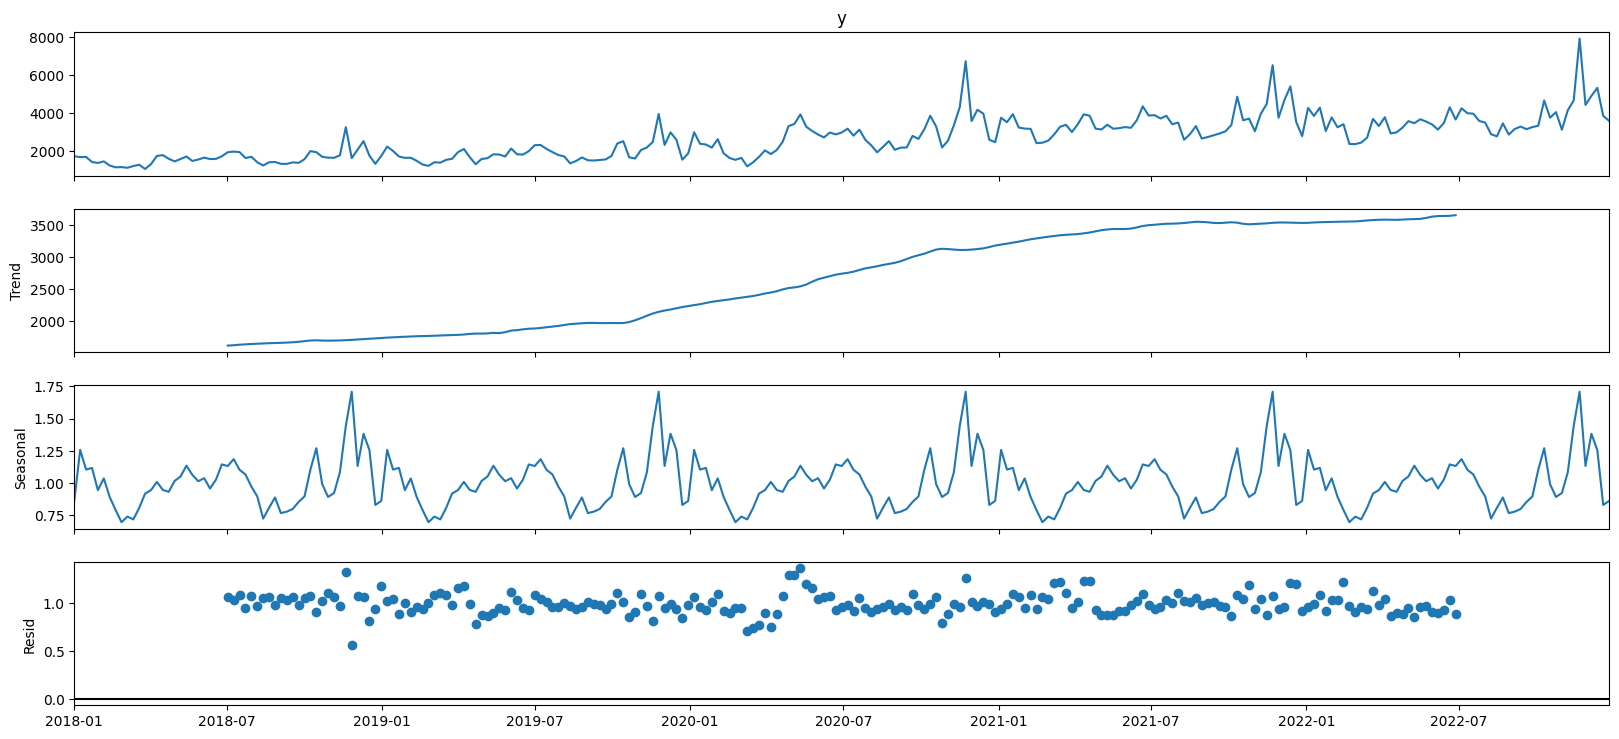

In [199]:
decomposed = seasonal_decompose(df['y'],model='mutiplicative',period=52)
fig = decomposed.plot()
fig.set_size_inches(18,8)
plt.show()

### STL decomposition

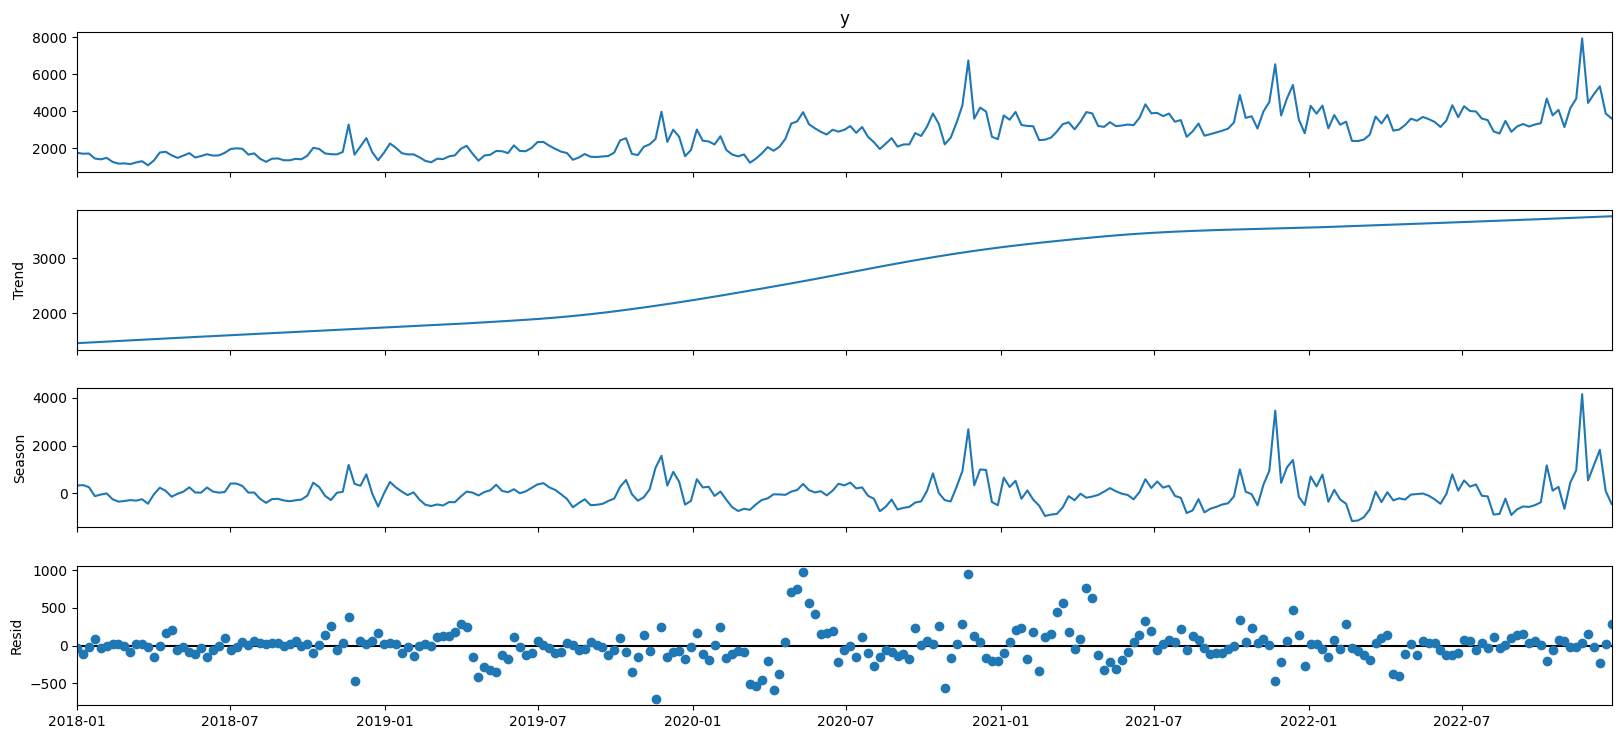

In [200]:
decomposed_stl = STL(df['y'],period=52).fit()
fig = decomposed_stl.plot()
fig.set_size_inches(18,8)
plt.show()

### seasonal plots

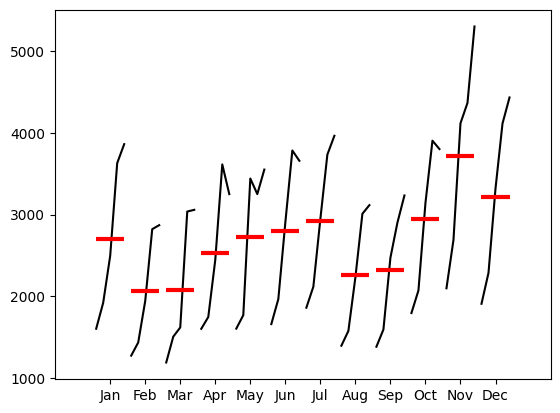

In [109]:
month_plot(df['y'].resample('ME').mean())
plt.show()

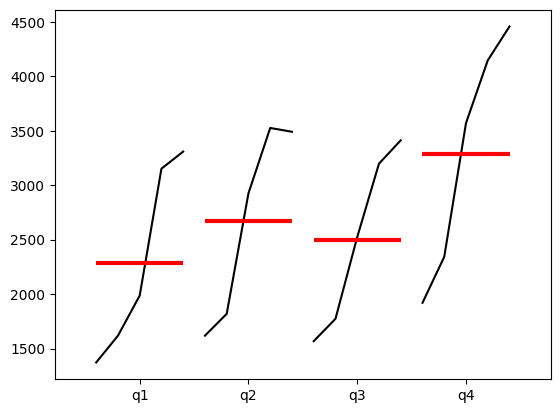

In [110]:
quarter_plot(df['y'].resample('QE').mean())
plt.show()

### Auto and partial auto correlation

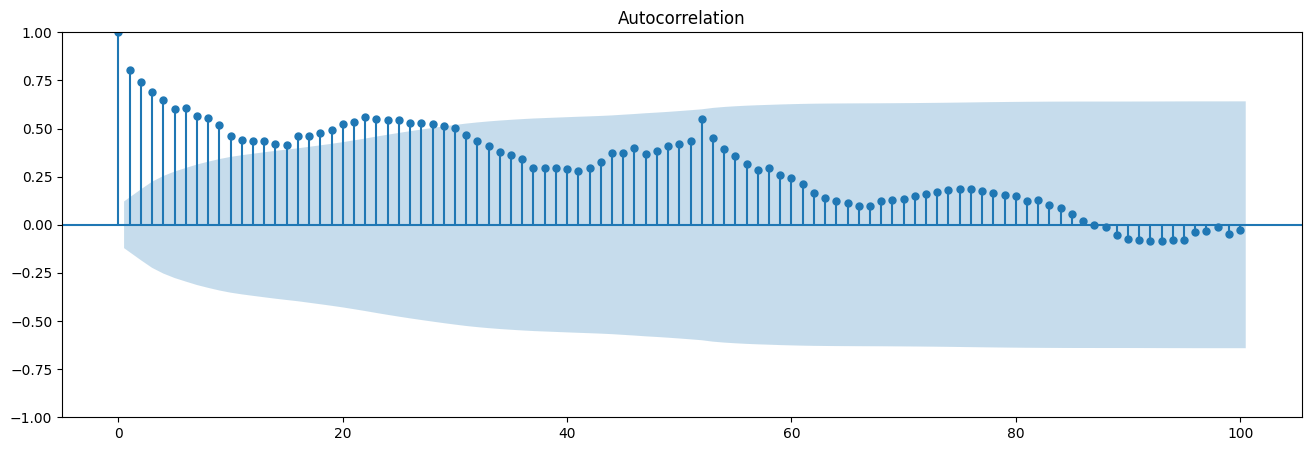

In [111]:
fig,ax = plt.subplots(figsize=(16,5))
plot_acf(df['y'],lags=100,ax=ax)
plt.show()

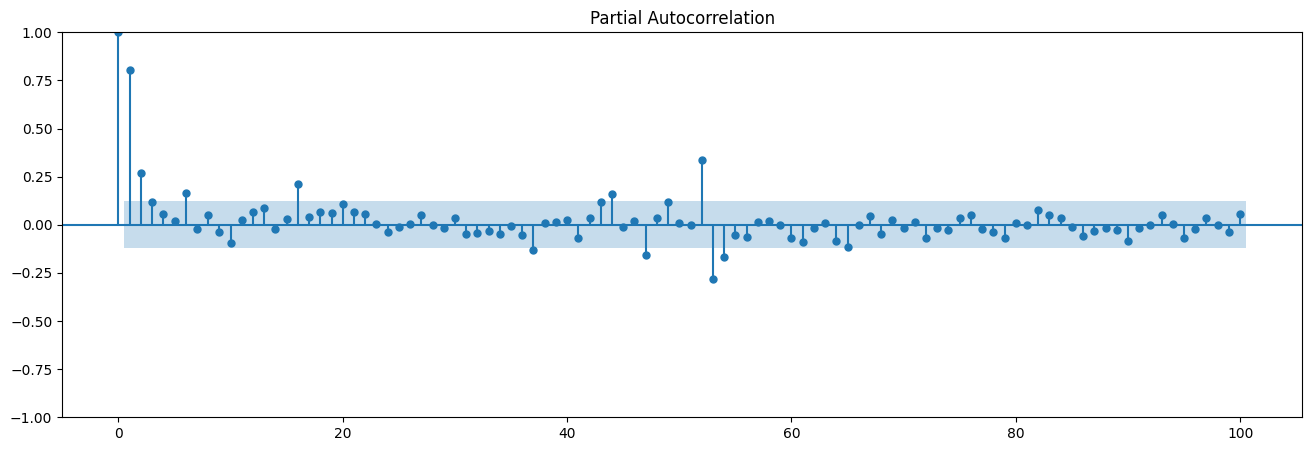

In [112]:
fig,ax = plt.subplots(figsize=(16,5))
plot_pacf(df['y'],lags=100,ax=ax)
plt.show()

### Train-Test split

(248, 1) (13, 1)
                       SimpleExpSmoothing Model Results                       
Dep. Variable:                      y   No. Observations:                  248
Model:             SimpleExpSmoothing   SSE                       74355478.081
Optimized:                       True   AIC                           3131.513
Trend:                           None   BIC                           3138.540
Seasonal:                        None   AICC                          3131.678
Seasonal Periods:                None   Date:                 Sun, 25 Jan 2026
Box-Cox:                        False   Time:                         16:52:10
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5097818                alpha                 True
initial_level              1750.000

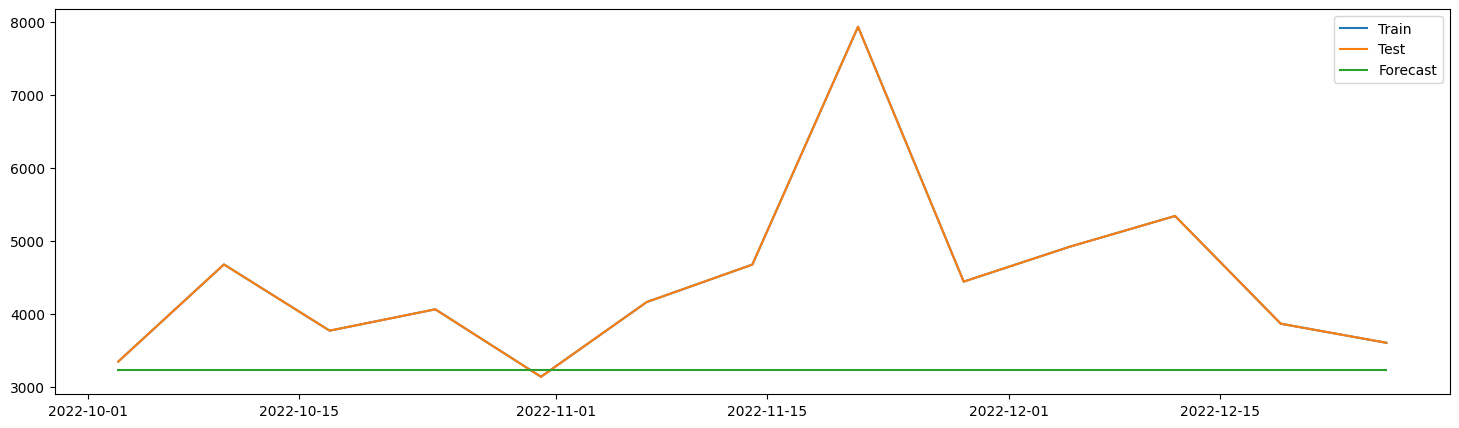

In [133]:
#back testing for 13 weeks
periods = 13
train = df[:-periods]
test = df[-periods:]

print(train.shape, test.shape)

from statsmodels.tsa.holtwinters import SimpleExpSmoothing

initial_level = int(train.iloc[0,0])
ses = SimpleExpSmoothing(train).fit(optimized=True)
forecast = ses.forecast(13)

print(ses.summary())

test.loc[:,['forecast']] = forecast

fig = plt.figure(figsize=(18,5))
plt.plot(test.loc['2022']['y'],label='Train')
plt.plot(test.loc['2022']['y'],label='Test')
plt.plot(test.loc['2022']['forecast'],label='Forecast')
plt.legend()
plt.show()

test.loc[:,['residuals']] = test['y'] - test['forecast']


(248, 1) (13, 1)
                       ExponentialSmoothing Model Results                       
Dep. Variable:                        y   No. Observations:                  248
Model:             ExponentialSmoothing   SSE                       74351169.240
Optimized:                         True   AIC                           3131.499
Trend:                             None   BIC                           3138.525
Seasonal:                          None   AICC                          3131.663
Seasonal Periods:                  None   Date:                 Sun, 25 Jan 2026
Box-Cox:                          False   Time:                         17:40:50
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5093686                alpha                 True
initial_level    

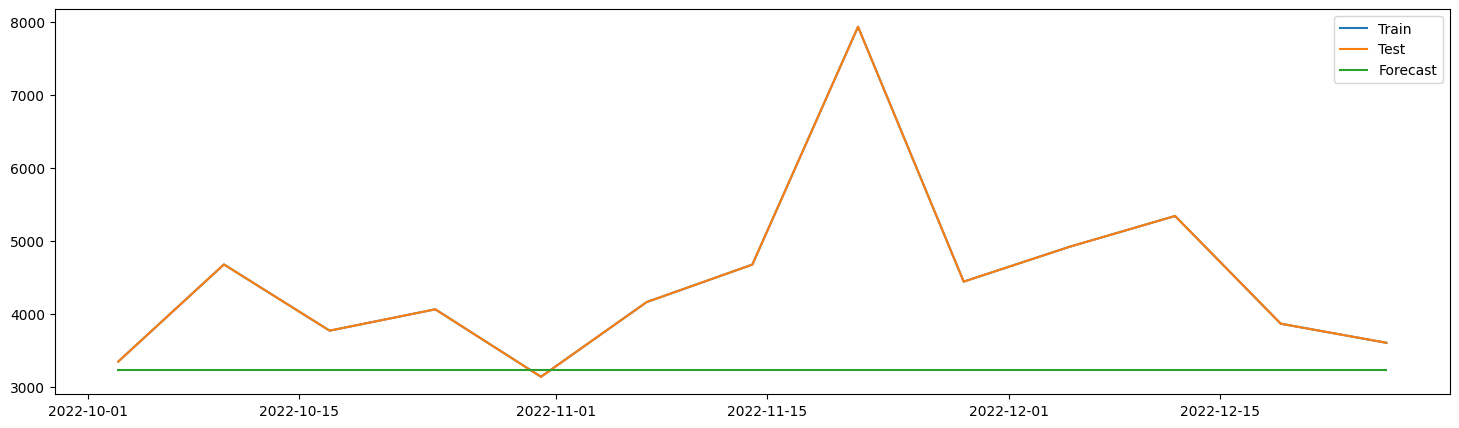

In [178]:
#back testing for 13 weeks
periods = 13
train = df[:-periods]
test = df[-periods:]

print(train.shape, test.shape)

from statsmodels.tsa.holtwinters import ExponentialSmoothing

initial_level = int(train.iloc[0,0])
ses = ExponentialSmoothing(endog=train,trend=None, seasonal=None).fit(optimized=True)
forecast = ses.forecast(13)

print(ses.summary())

test.loc[:,['forecast']] = forecast

fig = plt.figure(figsize=(18,5))
plt.plot(test.loc['2022']['y'],label='Train')
plt.plot(test.loc['2022']['y'],label='Test')
plt.plot(test.loc['2022']['forecast'],label='Forecast')
plt.legend()
plt.show()

test.loc[:,['residuals']] = test['y'] - test['forecast']


In [136]:
test.head()

,y,forecast,residuals
week,,,
2022-10-03,3350,3236.66347,113.33653
2022-10-10,4679,3236.66347,1442.33653
2022-10-17,3773,3236.66347,536.33653
2022-10-24,4065,3236.66347,828.33653
2022-10-31,3142,3236.66347,-94.66347


In [134]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

mae = mean_absolute_error(test['y'],test['forecast'][-periods:])
rmse = root_mean_squared_error(test['y'],test['forecast'][-periods:])
print(mae, rmse)


1236.5155252135928 1694.0329061312264


In [163]:
alpha = 0.50
level = train['y'].iloc[0]
print(level)

levels = [level]

for y in train.y:
    level = alpha * y + (1 - alpha) * level
    levels.append(level)

train.loc[:,'level'] = levels[:-1]



1750


In [ ]:
0.5 * 1711 + (1 - 0.5) *1718

1718.25

In [172]:
0.5 * 3279 + (1 - 0.5) * 3192.39462

3235.69731

### Double Exponential smoothening

(248, 1) (13, 1)
                       ExponentialSmoothing Model Results                       
Dep. Variable:                        y   No. Observations:                  248
Model:             ExponentialSmoothing   SSE                       74343961.206
Optimized:                         True   AIC                           3135.474
Trend:                         Additive   BIC                           3149.528
Seasonal:                          None   AICC                          3135.823
Seasonal Periods:                  None   Date:                 Sun, 25 Jan 2026
Box-Cox:                          False   Time:                         17:39:34
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5093869                alpha                 True
smoothing_trend  

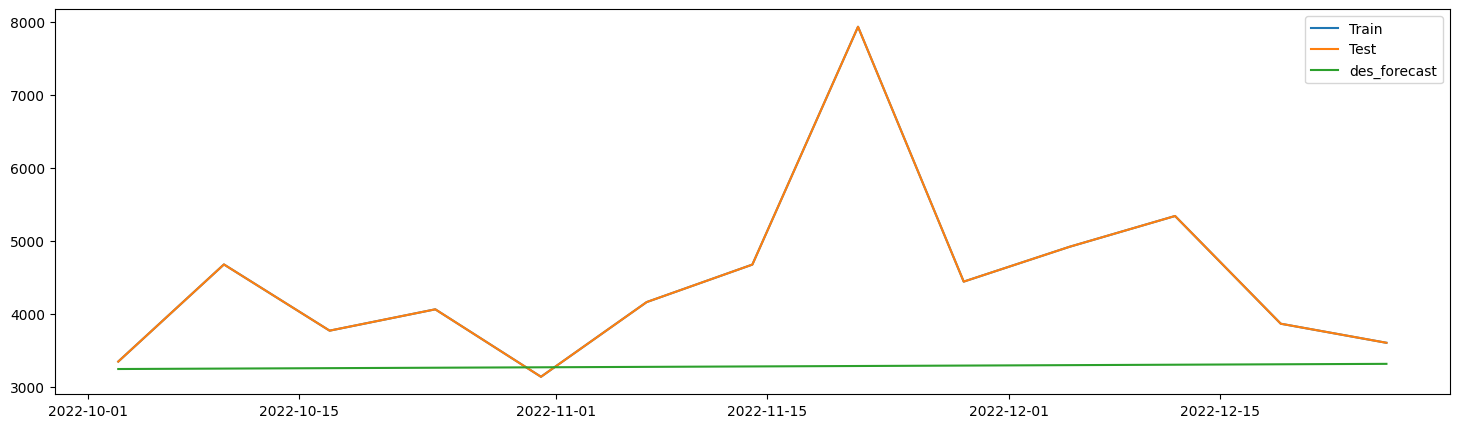

In [177]:
#back testing for 13 weeks
periods = 13
train = df[:-periods]
test = df[-periods:]

print(train.shape, test.shape)

from statsmodels.tsa.holtwinters import ExponentialSmoothing

des = ExponentialSmoothing(endog = train, trend = 'add',seasonal=None).fit(optimized=True)
des_forecast = des.forecast(13)

print(des.summary())

test.loc[:,['des_forecast']] = des_forecast

fig = plt.figure(figsize=(18,5))
plt.plot(test['y'],label='Train')
plt.plot(test['y'],label='Test')
plt.plot(test['des_forecast'],label='des_forecast')
plt.legend()
plt.show()

test.loc[:,['des_residuals']] = test['y'] - test['des_forecast']


### Triple Exponential Smoothening

(248, 1) (13, 1)
                       ExponentialSmoothing Model Results                       
Dep. Variable:                        y   No. Observations:                  248
Model:             ExponentialSmoothing   SSE                       21600694.894
Optimized:                         True   AIC                           2932.952
Trend:                         Additive   BIC                           3129.704
Seasonal:                Multiplicative   AICC                          2969.164
Seasonal Periods:                    52   Date:                 Sun, 25 Jan 2026
Box-Cox:                          False   Time:                         17:50:33
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2491216                alpha                 True
smoothin

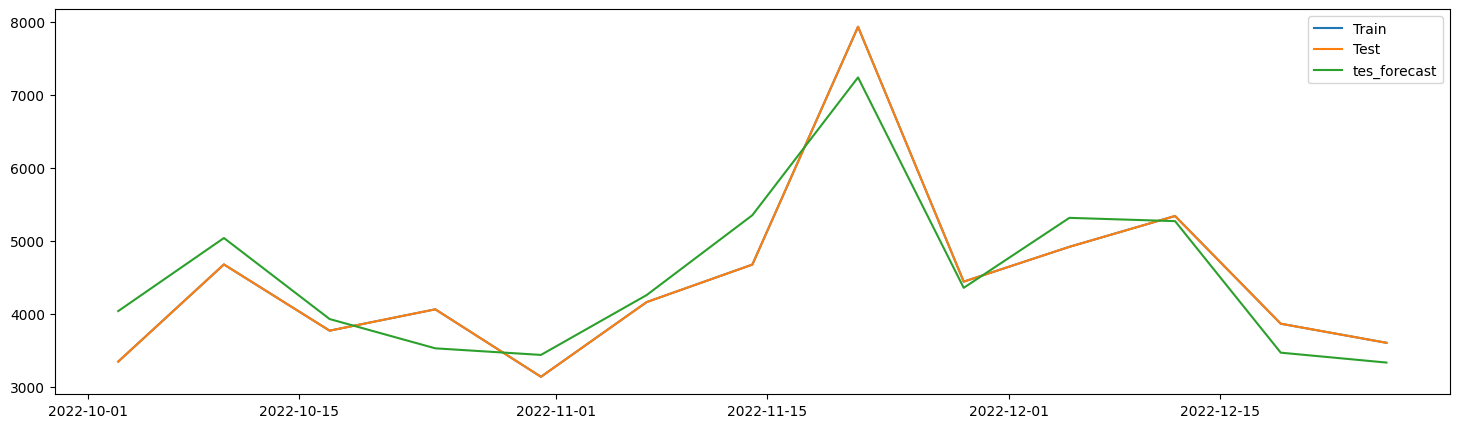

In [187]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

periods = 13
train = df[:-periods]
test = df[-periods:]
print(train.shape, test.shape)

tes = ExponentialSmoothing(endog = train, trend = 'add',seasonal='mul').fit(optimized=True)
tes_forecast = tes.forecast(13)
print(tes.summary())
test.loc[:,['tes_forecast']] = tes_forecast
fig = plt.figure(figsize=(18,5))
plt.plot(test['y'],label='Train')
plt.plot(test['y'],label='Test')
plt.plot(test['tes_forecast'],label='tes_forecast')
plt.legend()
plt.show()
test.loc[:,['tes_residuals']] = test['y'] - test['tes_forecast']


array([4041.17378869, 5040.6925099 , 3931.95844055, 3531.2124282 ,
       3441.1508388 , 4260.17546457, 5352.70761644, 7238.18174775,
       4359.0576212 , 5316.5652244 , 5271.41184082, 3471.86408549,
       3336.59630173])

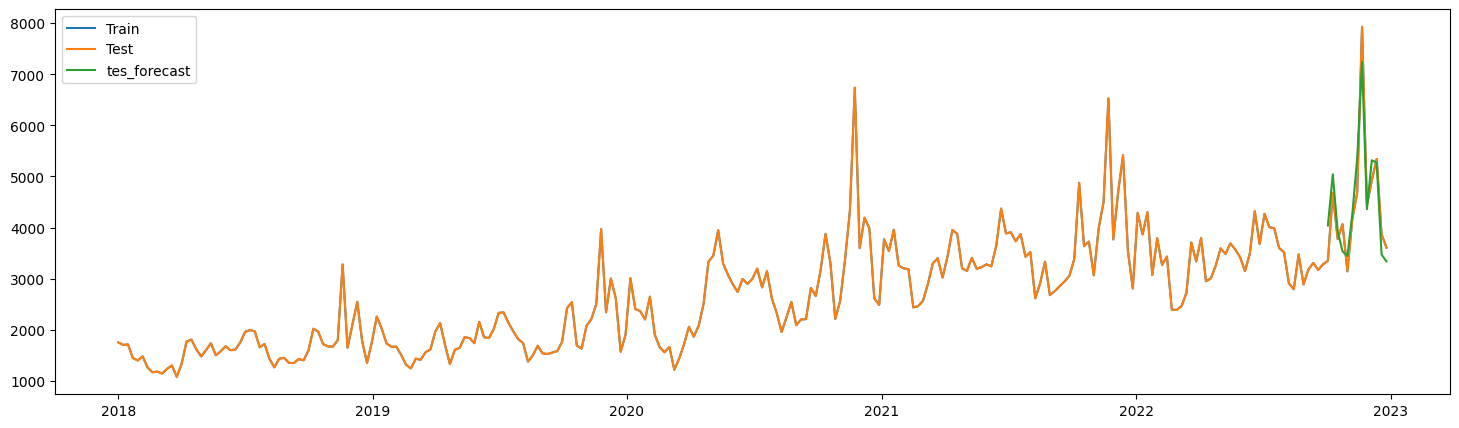

In [ ]:
df['tes_forecast'] = tes_forecast
fig = plt.figure(figsize=(18,5))

plt.plot(df['y'],label='Train')
plt.plot(df['y'],label='Test')
plt.plot(df['tes_forecast'],label='tes_forecast')
plt.legend()
plt.show()

In [195]:
df.tail()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2022-11-28,"4,444",29.89%,0,1,0
2022-12-05,"4,920",28.48%,1,0,0
2022-12-12,"5,342",28.89%,0,0,0
2022-12-19,"3,868",33.26%,0,0,0
2022-12-26,"3,607",37.35%,0,1,0


In [220]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_es = ExponentialSmoothing(endog=df['y'],
                                 trend = 'add',
                                 seasonal = 'mul',
                                 seasonal_periods=52).fit()
forecast_es = model_es.forecast(105)
full_df = pd.concat([df,forecast_es.rename('forecast')]).fillna(0)

In [221]:
full_df.tail()

,y,forecast
2024-12-02,0.0,6481.563583
2024-12-09,0.0,6616.413326
2024-12-16,0.0,4497.645543
2024-12-23,0.0,4275.637567
2024-12-30,0.0,6097.541053


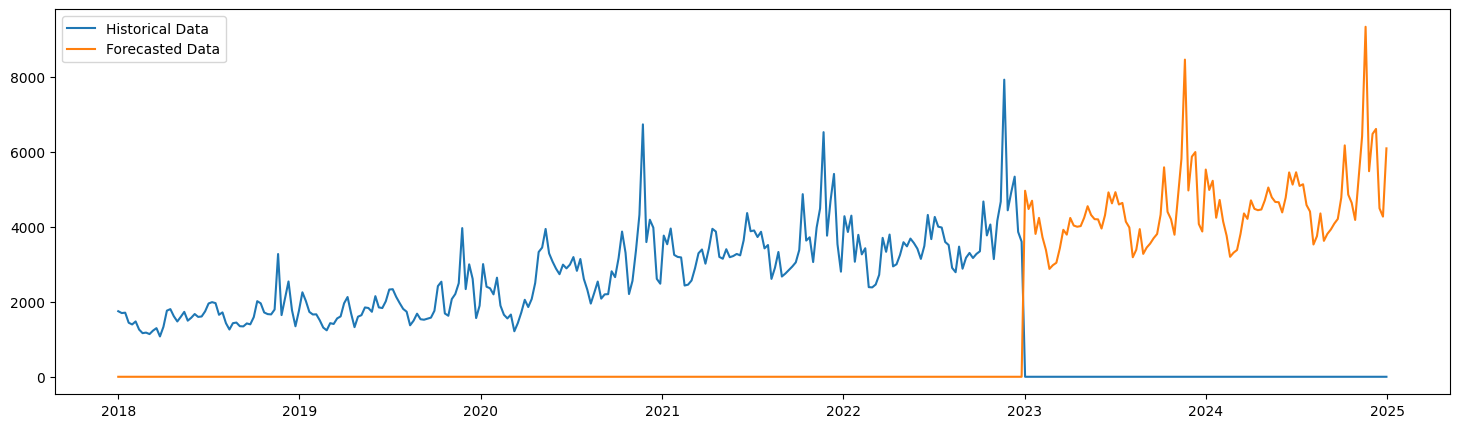

In [222]:
def plot_future(y,forecast):
    fig = plt.figure(figsize=(18,5))
    plt.plot(y,label='Historical Data')
    plt.plot(forecast,label='Forecasted Data')
    plt.legend()
    plt.show()

plot_future(full_df.y,full_df.forecast)